In [1]:
import fitz  # PyMuPDF
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import hypernetx as hnx
import matplotlib.pyplot as plt
import ollama
import numpy as np

import warnings
warnings.filterwarnings("ignore", module="urllib3")

In [2]:
nltk.download('punkt', quiet=True)

True

In [3]:
def extract_text(pdf_path):
    """Extract text from PDF using PyMuPDF"""
    with fitz.open(pdf_path) as doc:
        return [page.get_text() for page in doc]

def preprocess_text(text_pages, min_word_length=3, custom_denylist=None):
    """
    Clean and tokenize text for topic modeling/hypergraph construction.
    - Lowercases words
    - Removes non-alphabetic tokens
    - Removes short words (default <3 chars)
    - Removes custom denylist words (e.g., "fig", "eq", "ref")
    Returns: list of lists (each sublist = words from one document/page)
    """
    if custom_denylist is None:
        # Common LaTeX and academic artifacts to remove
        custom_denylist = {"fig", "eq", "ref", "table", "et", "al", "figure", "section", "tab"}
    
    processed = []
    for doc in text_pages:
        tokens = [
            word.lower()
            for word in word_tokenize(doc)
            if word.isalpha()
            and len(word) >= min_word_length
            and word.lower() not in custom_denylist
        ]
        if tokens:
            processed.append(tokens)
    return processed

def create_lda_model(processed_text, num_topics=8, passes=15):
    """Train and validate LDA model"""
    dictionary = corpora.Dictionary(processed_text)
    corpus = [dictionary.doc2bow(text) for text in processed_text]
    
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=passes,
        random_state=42
    )
    
    # Validate model quality
    coherence = CoherenceModel(
        model=lda,
        texts=processed_text,
        dictionary=dictionary,
        coherence='c_v'
    ).get_coherence()
    print(f"Coherence Score: {coherence:.2f} (0.4+ = acceptable)")
    
    return lda, dictionary

def build_hypergraph(lda_model):
    """Construct hypernetx graph from an optimized LDA model"""
    num_topics = lda_model.num_topics
    hyperedges = {
        f"Topic_{i}": {word for word, _ in lda_model.show_topic(i)}
        for i in range(num_topics)
    }
    return hnx.Hypergraph(hyperedges)

def visualize_hypergraph(H, title="Research Paper Topic Hypergraph"):
    """Draw interactive hypergraph visualization"""
    hnx.drawing.draw(H)
    plt.title(title)
    plt.show()

def generate_questions(topic_words, num_questions=3):
    """Query local Zephyr model via Ollama"""
    response = ollama.chat(
        model='zephyr',
        messages=[{
            'role': 'user',
            'content': f"Generate {num_questions} diverse quiz questions about: {', '.join(topic_words)}"
        }],
        options={'temperature': 0.5}
    )
    return response['message']['content']


def optimize_lda(processed_text, max_topics=40, step=5):
    """End-to-end LDA optimization pipeline"""
    # Create dictionary and corpus
    dictionary = corpora.Dictionary(processed_text)
    corpus = [dictionary.doc2bow(text) for text in processed_text]
    
    # Stage 1: Find optimal topic count
    print("Optimizing number of topics...")
    model_list, coherence_values = compute_coherence_values(
        dictionary, corpus, processed_text, 
        start=2, limit=max_topics, step=step
    )
    
    # Visualize topic coherence
    x = range(2, max_topics, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Topic Coherence Optimization")
    plt.show()
    
    # Stage 2: Tune hyperparameters for best topic count
    best_idx = np.argmax(coherence_values)
    optimal_topics = x[best_idx]
    print(f"\nOptimal topics: {optimal_topics} (Coherence: {coherence_values[best_idx]:.2f})")
    
    print("\nTuning hyperparameters...")
    best_model, best_alpha, best_beta, best_coherence = tune_hyperparameters(
        dictionary, corpus, processed_text, optimal_topics
    )
    
    return best_model, {
        'topics': optimal_topics,
        'alpha': best_alpha,
        'beta': best_beta,
        'coherence': best_coherence
    }

def compute_coherence_values(dictionary, corpus, texts, start=2, limit=40, step=5):
    """Calculate coherence scores for different topic counts"""
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=15,
            alpha='auto',
            eta='auto'
        )
        model_list.append(model)
        
        coherence = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        ).get_coherence()
        
        coherence_values.append(coherence)
        print(f"Topics: {num_topics} | Coherence: {coherence:.3f}")
        
    return model_list, coherence_values

def tune_hyperparameters(dictionary, corpus, texts, num_topics):
    """Optimize alpha and beta parameters"""
    best_coherence = -1
    best_params = {}
    best_model = None
    
    # Parameter grids from search results [2]
    alpha_values = list(np.round(np.arange(0.01, 1, 0.3), 2)) + ['symmetric', 'asymmetric']
    beta_values = list(np.round(np.arange(0.01, 1, 0.3), 2)) + ['auto']
    
    for alpha in alpha_values:
        for beta in beta_values:
            try:
                model = LdaModel(
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=num_topics,
                    alpha=alpha,
                    eta=beta,
                    passes=25,
                    random_state=42
                )
                
                coherence = CoherenceModel(
                    model=model,
                    texts=texts,
                    dictionary=dictionary,
                    coherence='c_v'
                ).get_coherence()
                
                if coherence > best_coherence:
                    best_coherence = coherence
                    best_params = {'alpha': alpha, 'beta': beta}
                    best_model = model
                    
                    print(f"New best: α={alpha}, β={beta} | Coherence: {coherence:.3f}")
                    
            except Exception as e:
                continue
                
    return best_model, best_params['alpha'], best_params['beta'], best_coherence

In [4]:
text = extract_text('/Users/viveksaravanan/Documents/sjsu/SP25/engr295b/content/nnoverview.pdf')
processed_text = preprocess_text(text)

Optimizing number of topics...
Topics: 2 | Coherence: 0.282
Topics: 7 | Coherence: 0.264
Topics: 12 | Coherence: 0.259
Topics: 17 | Coherence: 0.262
Topics: 22 | Coherence: 0.268
Topics: 27 | Coherence: 0.269
Topics: 32 | Coherence: 0.276
Topics: 37 | Coherence: 0.292


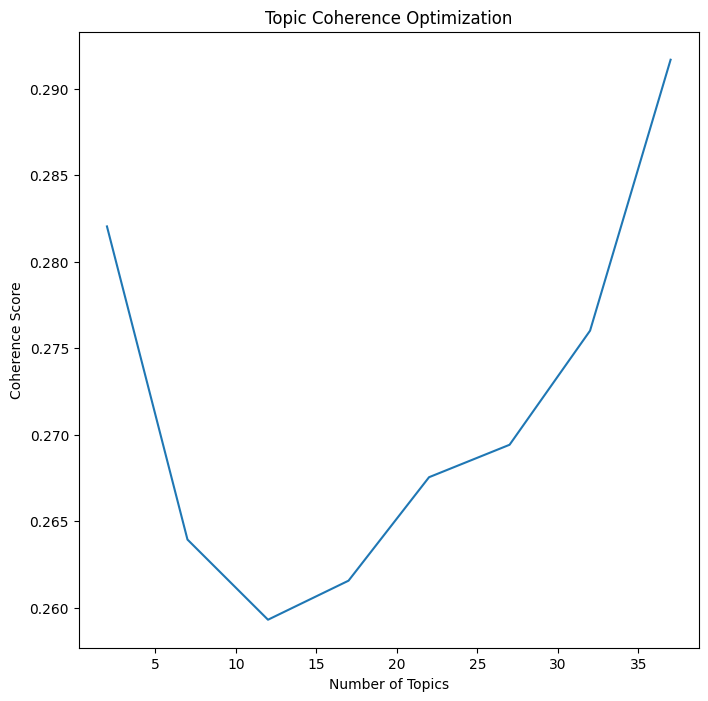


Optimal topics: 37 (Coherence: 0.29)

Tuning hyperparameters...
New best: α=0.01, β=0.01 | Coherence: 0.292
New best: α=0.01, β=0.31 | Coherence: 0.296
New best: α=0.61, β=0.31 | Coherence: 0.323
New best: α=0.91, β=0.31 | Coherence: 0.449

=== Optimal Parameters ===
Topics: 37
Alpha: 0.91
Beta: 0.31
Coherence: 0.449

=== Top Topics ===
Topic 35: 0.001*"the" + 0.001*"neural" + 0.001*"and" + 0.001*"are" + 0.001*"network" + 0.001*"networks" + 0.001*"each" + 0.001*"generalization" + 0.001*"context" + 0.001*"that"

Topic 23: 0.001*"the" + 0.001*"and" + 0.001*"neural" + 0.001*"network" + 0.001*"networks" + 0.001*"are" + 0.001*"generalization" + 0.001*"context" + 0.001*"that" + 0.001*"concepts"

Topic 11: 0.094*"the" + 0.022*"and" + 0.019*"neural" + 0.015*"network" + 0.013*"are" + 0.012*"output" + 0.010*"nodes" + 0.010*"this" + 0.008*"propagation" + 0.008*"neuron"

Topic 27: 0.001*"the" + 0.001*"neural" + 0.001*"and" + 0.001*"are" + 0.001*"network" + 0.001*"that" + 0.001*"networks" + 0.001*

In [5]:
lda_model, params = optimize_lda(processed_text)
    
print("\n=== Optimal Parameters ===")
print(f"Topics: {params['topics']}")
print(f"Alpha: {params['alpha']}")
print(f"Beta: {params['beta']}")
print(f"Coherence: {params['coherence']:.3f}")
    
    # Show final topics
print("\n=== Top Topics ===")
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}: {topic}\n")

/Users/viveksaravanan/Documents/sjsu/SP25/engr295b/GraphRAG-with-Llama-3.1-main/venv-grag/lib/python3.9/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/viveksaravanan/Documents/sjsu/SP25/engr295b/GraphRAG-with-Llama-3.1-main/venv-grag/lib/python3.9/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/viveksaravanan/Documents/sjsu/SP25/engr295b/GraphRAG-with-Llama-3.1-main/venv-grag/lib/python3.9/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

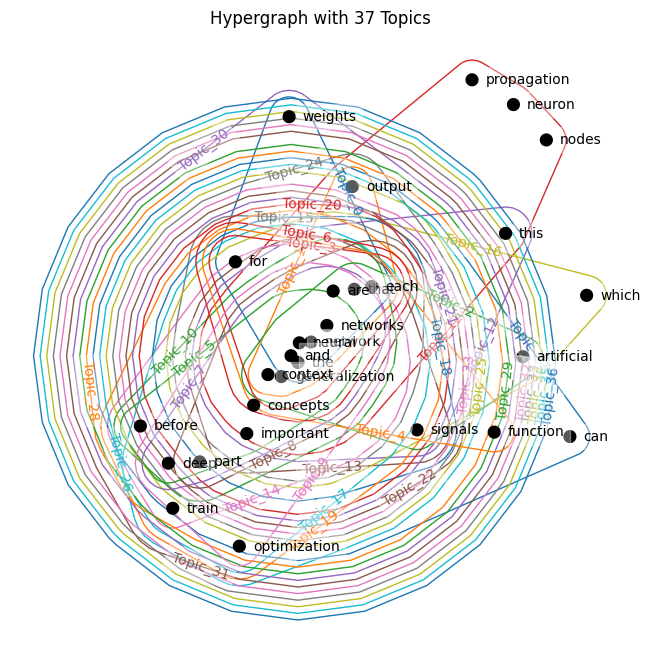

In [7]:
H = build_hypergraph(lda_model)
visualize_hypergraph(H, title=f"Hypergraph with {lda_model.num_topics} Topics")

In [6]:
# hypergnn_integration.py
import torch
import dgl
import torch.nn as nn
import torch.nn.functional as F
import hypernetx as hnx

class HypergraphConv(nn.Module):
    def __init__(self, in_feats, out_feats):
        super().__init__()
        self.weight = nn.Linear(in_feats, out_feats)
        
    def forward(self, g, features):
        with g.local_scope():
            # Explicitly set features for node type
            g.nodes['node'].data['h'] = features
            
            # Step 1: Node -> Edge aggregation
            g.update_all(
                dgl.function.copy_u('h', 'm'),
                dgl.function.mean('m', 'h_edge'),
                etype='in'
            )
            
            # Step 2: Edge -> Node aggregation
            g.update_all(
                dgl.function.copy_u('h_edge', 'm'),
                dgl.function.mean('m', 'h_node'),
                etype='contains'
            )
            
            return self.weight(g.nodes['node'].data['h_node'])

def hypergraph_to_dgl(H):
    """Convert hypernetx hypergraph to DGL heterograph"""
    node_list = list(H.nodes)
    edge_list = list(H.edges)
    
    src, dst = [], []
    for edge_id, members in H.incidence_dict.items():
        for node in members:
            src.append(node_list.index(node))
            dst.append(edge_list.index(edge_id))
    
    return dgl.heterograph({
        ('node', 'in', 'edge'): (src, dst),
        ('edge', 'contains', 'node'): (dst, src)
    })

def train_hypergnn(H, lda_model, num_epochs=100):
    g = hypergraph_to_dgl(H)
    node_list = list(H.nodes)
    
    # Initialize node features (for 'node' type only)
    node_features = torch.zeros(len(node_list), lda_model.num_topics)
    for idx, node in enumerate(node_list):
        topics = lda_model.get_term_topics(node) or []
        for topic, prob in topics:
            node_features[idx, topic] = float(prob)
    
    # Model and optimizer
    model = HypergraphConv(lda_model.num_topics, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        embeddings = model(g, node_features)
        loss = contrastive_loss(embeddings, H)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss {loss.item():.4f}")
    
    return model, embeddings

def contrastive_loss(embeddings, H, margin=1.0):
    """Contrastive loss with proper node indexing"""
    node_list = list(H.nodes)
    num_nodes = len(node_list)
    
    # Positive pairs (same hyperedge)
    pos_pairs = []
    for edge in H.edges:
        members = list(H.edges[edge])
        indices = [node_list.index(n) for n in members]
        pos_pairs.extend([(i,j) for i in indices for j in indices if i != j])
    
    # Negative pairs (different hyperedges)
    neg_pairs = []
    for i in range(num_nodes):
        neighbors = set()
        for edge in H.edges:
            if node_list[i] in H.edges[edge]:
                neighbors.update(H.edges[edge])
        non_neighbors = [node_list.index(n) for n in node_list 
                        if n not in neighbors and n != node_list[i]]
        neg_pairs.extend([(i,j) for j in non_neighbors])
    
    if not pos_pairs or not neg_pairs:
        return torch.tensor(0.0, requires_grad=True)
    
    # Calculate losses
    pos_loss = F.pairwise_distance(
        embeddings[torch.tensor([i for i,j in pos_pairs])],
        embeddings[torch.tensor([j for i,j in pos_pairs])]
    ).mean()
    
    neg_loss = F.relu(margin - F.pairwise_distance(
        embeddings[torch.tensor([i for i,j in neg_pairs])],
        embeddings[torch.tensor([j for i,j in neg_pairs])]
    )).mean()
    
    return pos_loss + neg_loss


In [8]:
model, embeddings = train_hypergnn(H, lda_model)

Epoch 0: Loss 0.9990
Epoch 10: Loss 0.9988
Epoch 20: Loss 0.9987
Epoch 30: Loss 0.9986
Epoch 40: Loss 0.9985
Epoch 50: Loss 0.9983
Epoch 60: Loss 0.9982
Epoch 70: Loss 0.9981
Epoch 80: Loss 0.9980
Epoch 90: Loss 0.9978


In [44]:
def generate_questions(H, embeddings, num_questions=5, difficulty="medium"):
    """
    Generate MCQ questions using hypergraph context and embeddings
    difficulty: 'easy', 'medium', or 'hard'
    """
    # Get hypergraph context
    context = []
    for edge_id in H.edges:
        concepts = list(H.edges[edge_id])
        # Get average embedding for this hyperedge
        concept_indices = [list(H.nodes).index(c) for c in concepts]
        avg_embedding = torch.mean(embeddings[concept_indices], dim=0).tolist()
        
        context.append(
            f"Topic {edge_id}: {', '.join(concepts)}\n"
            f"Relationship Strength: {avg_embedding[:3]}..."  # Show first 3 values
        )
    
    # Build prompt
    prompt = f"""
    Generate {num_questions} {difficulty} multiple-choice questions about these topics:
    
    Context:
    {''.join(context)}
    
    Guidelines:
    - For easy questions: Focus on basic recall and understanding of concepts
    - For medium questions: Focus on relationships between concepts and application
    - For hard questions: Focus on synthesis across multiple concepts and critical thinking

    For each question:
            1. Generate a clear question
            2. Provide exactly 4 options labeled A, B, C, D.
            3. Write each answer option as a complete phrase or sentence, not just a concept label
            4. Indicate the correct answer
            5. Provide a brief explanation (1-2 sentences) for why the correct answer is right
            6. Ensure distractors (wrong options) are plausible but clearly incorrect
            
            Example:
            Question: Which of the following actions was taken by Abraham Lincoln during the Civil War?
            A. He issued the Emancipation Proclamation.
            B. He led the Confederate Army.
            C. He supported the secession of Southern states.
            D. He resigned from the presidency.
            Correct Answer: A
            Explanation: Abraham Lincoln issued the Emancipation Proclamation in 1863, which declared slaves in rebelling states to be free.
            
            Format each question EXACTLY as follows:
            
            Question: [Question text]
            A. [Option A]
            B. [Option B]
            C. [Option C]
            D. [Option D]
            Correct Answer: [Letter of correct option]
            Explanation: [Brief explanation of why the correct answer is right]

    Important Rules:
        1. Do NOT include difficulty levels like '(Easy)' in question text
        2. Never put difficulty labels after question numbers
        3. Keep questions focused on content, not difficulty
    
    Generate EXACTLY {num_questions} questions in this format, numbered from 1 to {num_questions}.:
    """
    
    # Get LLM response
    response = ollama.chat(
        model='zephyr',
        messages=[{'role': 'user', 'content': prompt}],
        options={'temperature': 0.7}
    )
    
    return parse_questions(response['message']['content'])

import re

def parse_questions(raw_text: str) -> List[Dict[str, Any]]:
    """Robust question parser handling multi-line explanations and format variations"""
    questions = []
    current_q = {
        'question': '',
        'options': {},
        'correct': None,
        'explanation': None
    }
    lines = raw_text.strip().split('\n')
    i = 0
    
    while i < len(lines):
        line = lines[i].strip()
        
        if not line:
            i += 1
            continue
            
        # Detect question start (case-insensitive)
        if re.match(r'^question\s*\d*[:.]?', line, re.IGNORECASE):
            if current_q['question']:
                questions.append(current_q)
                current_q = {
                    'question': '',
                    'options': {},
                    'correct': None,
                    'explanation': None
                }
            
            # Extract question text
            question_text = re.sub(r'^question\s*\d*[:.]?\s*', '', line, flags=re.IGNORECASE)
            current_q['question'] = question_text.strip()
            i += 1
            continue
            
        # Detect options (A. ..., B) ..., etc.)
        option_match = re.match(r'^([A-Z])[\.\)]\s*(.+)', line)
        if option_match:
            option_letter = option_match.group(1).upper()
            option_text = option_match.group(2).strip()
            current_q['options'][option_letter] = option_text
            i += 1
            continue
            
        # Detect correct answer (case-insensitive)
        if re.match(r'^(correct )?answer[:.]?', line, re.IGNORECASE):
            answer_text = re.sub(r'^(correct )?answer[:.]?\s*', '', line, flags=re.IGNORECASE)
            current_q['correct'] = answer_text.strip()[0].upper()  # Take first character
            i += 1
            continue
            
        # Detect and handle multi-line explanations
        if re.match(r'^explanation[:.]?', line, re.IGNORECASE):
            explanation = re.sub(r'^explanation[:.]?\s*', '', line, flags=re.IGNORECASE)
            
            # Collect continuation lines
            while i+1 < len(lines) and not re.match(r'^(question|correct answer|explanation)', lines[i+1], re.IGNORECASE):
                i += 1
                explanation += " " + lines[i].strip()
                
            current_q['explanation'] = explanation.strip()
            i += 1
            continue
            
        i += 1  # Skip unrecognized lines

    # Add final question
    if current_q['question']:
        questions.append(current_q)
        
    return [q for q in questions]


In [45]:
# Generate 3 medium questions
questions = generate_questions(
    H=H,
    embeddings=embeddings,
    num_questions=5,
    difficulty="easy"
)

# Validate against hypergraph terms
#valid_questions = validate_questions(questions, H)

# Print results
for i, q in enumerate(questions):
    print(f"\nQuestion {i+1}: {q['question']}")
    for opt, text in q['options'].items():
        print(f"  {opt}. {text}")
    print(f"Correct Answer: {q['correct']}")
    print(f"Explanation: {q['explanation']}")



Question 1: Which of the following is an example of a function in neural networks?
  A. A collection of neurons that perform a specific task
  B. The process by which data is inputted into a neural network
  C. An algorithm used to optimize weights in a neural network
  D. A mathematical equation that maps inputs to outputs
Correct Answer: D
Explanation: Functions are an essential component of neural networks, and they represent the relationship between inputs and outputs. They are mathematical equations that map inputs to outputs and enable the network to learn and make predictions.

Question 2: What is the process known as in which a neural network learns from data?
  A. Propagation
  B. Forward propagation
  C. Backpropagation
  D. Weights optimization
Correct Answer: C
Explanation: Backpropagation is the process by which a neural network learns from data by adjusting its weights to minimize errors in predictions. It is an essential component of training deep learning models and is